## The output of the executed notebook is here: https://jovian.ml/ronaldokun/zero2gans-fastai2-3rd-place-solution

I was getting errors when commiting here on Kaggle but the notebook executed sucessfully

In [1]:
!pip install fastai2 torchviz

     |████████████████████████████████| 190 kB 4.6 MB/s 
     |████████████████████████████████| 41 kB 142 kB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3521 sha256=4e995d89d34a62f72c1540a99cc1fb0fd6846d40a3176a05751896f0dff4929e
  Stored in directory: /root/.cache/pip/wheels/10/7b/c8/3af79ec02e294a832c01037bcb38302bbcee0bb020dcbbbd3e
Successfully built torchviz


I've used Deep Learning, and particularly fastai, for some time now. Normally I was reluctant to share anything thinking is not going to be of much use, but motivated by this competition, I decided to try and share a notebook in pure Pytorch to show how to implement a Multilabel Stratification and Cross Validation strategy https://www.kaggle.com/ronaldokun/multilabel-stratification-cv-and-ensemble because I thought it was very important to have a competitive edge. I am glad I did that because the notebook proved useful for some, it motivated me to also try to write more pure Pytorch. 

I used this competition to learn the latest version of the fastai library, fastai2 (still in development but already ready to use). 

fastai is awesome, with a lot of advanced stuff and neat tricks already build in the library, but it can be somewhat of a "black box", hard to inspect and adapt the code because is vastly different than familiar python codebases. That's why I share my entire workflow here in fastai2 so it can be useful to others to get to know the library, use it and adapt to other competitions. 

* Update 2: 
 - Changing `alpha=0.5` and `thresh=0.3` in Focal Loss 
 - Doubling the `lr` with bigger images but only going to `image_size=256` 
 - Just 1 freeze epoch per cycle ( default )
 - using xresnet34
 - Using Simpler Transforms ( The Whole bunch from `aug_transforms` from fastai were harder to generalize )

## Imports

In [2]:
import multiprocessing as mp
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skmultilearn.model_selection import IterativeStratification
from fastai2.layers import *
from fastai2.vision.all import *
from fastai2.callback.core import *
from fastai2.optimizer import *
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc
import zipfile
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

      
ROOT = Path('../input/jovian-pytorch-z2g')
DIR = ROOT / 'Human protein atlas'
TRAIN = DIR / 'train'
TEST = DIR / 'test'
SEED = 2020
FOCAL = False
EPOCHS = 12
BATCH_SIZE = 8
IMG_SIZE = 512
eps = 1e-6
pct_start = 0.5
wd=1e-4


MODEL_PATH = Path('/kaggle/working/models')
MODEL_PATH.mkdir(exist_ok=True)

submission = pd.read_csv(ROOT / 'submission.csv')

## Statistics of the Dataset.
Many top competitors in Kaggle don't just use the Imagenet Statistics but calculate the Statistics of the current whole dataset ( train + test ) and use those instead. I lack expertise to know which is best but nevertheless I calculated the statistics of the current dataset. The values are already calculated, uncomment the following cell if you want to make the calculation yourself.

In [3]:
#all_files = list(TRAIN.iterdir()) + list(TEST.iterdir())
#x_tot, x2_tot = [], []
#for file in tqdm(files):
#    img = cv2.imread(str(file), cv2.COLOR_RGB2BGR)
#    img = img/255.0
#    x_tot.append(img.reshape(-1, 3).mean(0))
#    x2_tot.append((img**2).reshape(-1, 3).mean(0))

#image stats
#img_avr =  np.array(x_tot).mean(0)
#img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
#print('mean:',img_avr, ', std:', np.sqrt(img_std))
# -

In [4]:
mean = torch.tensor([[0.05438065, 0.05291743, 0.07920227]])
std = torch.tensor([[0.39414383, 0.33547948, 0.38544176]])

1. ## Helpers Functions to Create a Fastai V2 DataSet

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False # This seems to speed up the training without losing reproduction
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)
 

def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)


labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

indexes = {str(v):k for k,v in labels.items()}

def get_test_images(img_ids):
    return [f'{TEST}/{img_id}.png' for img_id in img_ids]

# Get the Image Files in the same order as the submission dataframe
test_images = get_test_images(submission.Image.tolist())

def create_split_df(nfolds=5, order=1):

    df = pd.read_csv(DIR / 'train.csv').sort_values("Image").reset_index(drop=True)

    split_df = pd.get_dummies(df.Label.str.split(" ").explode())

    split_df = split_df.groupby(split_df.index).sum() 

    X, y = split_df.index.values, split_df.values

    k_fold = IterativeStratification(n_splits=nfolds, order=order)

    splits = list(k_fold.split(X, y))

    fold_splits = np.zeros(df.shape[0]).astype(np.int)

    for i in range(nfolds):
        fold_splits[splits[i][1]] = i

    df['Split'] = fold_splits

    df_folds = []

    for fold in range(nfolds):

        df_fold = df.copy()
            
        df_fold['is_valid'] = False
        
        df_fold.loc[df_fold.Split == fold, 'is_valid'] = True
        
        df_folds.append(df_fold)

    return df_folds

def get_x(r):
    return f"{TRAIN}/{r['Image']}.png"

def get_y(r):    
    return [labels[int(l)] for l in r['Label'].split()]

def splitter(df, full_train=False):
    # If you want to use the whole training set, 
    # just sample one image from the more numerous class and with a single label as a dummy validation set
    if full_train:
        valid = df[(df.Label.str.contains('4')) & (df.Label.str.len() == 1)].sample(n=1)
        train = df.drop(valid.index, axis=0)        
        return valid.index.tolist(), train.index.tolist()
                
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    
    return train,valid


def get_dataloaders(df, bs, size, simple_aug=False, full_train=False):
    
    splt = partial(splitter, full_train=full_train)
    
    if simple_aug:
        tfms = setup_aug_tfms([Rotate(draw=90, p=0.5),
                               Brightness(max_lighting=0.4, p=0.75),
                               Dihedral(p=0.5),
                               Normalize.from_stats(mean, std)])
    else:       
        tfms = [*aug_transforms(size=size, min_scale=0.75, flip_vert=True),
                               Normalize.from_stats(mean, std)]
                
    item_tfms = Resize(size) if size < 512 else None
    
    dblock = DataBlock(get_x=get_x, 
                       get_y=get_y, 
                       blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=splt,
                       item_tfms=item_tfms, 
                       batch_tfms=tfms)
    
    return dblock.dataloaders(df, bs=bs, num_workers=mp.cpu_count()) #pin_memory=True returns an error


def data_iterator(nfolds=5, order_splits=2, bs=32, size=512, simple_aug=False, full_train=False, with_test=False):
    """ Helper function to lazily return nfolds of fastai dataloaders and optionally a test one
    """
    dfs = get_dfs(nfolds, order_splits)
    for df in dfs:
        dls = get_dataloaders(df, bs=bs, size=size, simple_aug=simple_aug, full_train=full_train)        
        if with_test:
            test_dl = dls.test_dl(test_images, shuffle=False, drop_last=False)
            yield dls, test_dl
        else:
            yield dls, None

**The function `aug_transforms` returns a bunch of augmentations, usually this is indicated for any image dataset. Nevertheless I've just used in the competition simple Flip, Rotation and Normalization from the Statistic derived above.** I'll use the more strong augmentations here.

## Helper Functions to fit the Thresholds
Adapted from Notable Kaggle Master iafoss
https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb

In [6]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    
    params = np.zeros(10)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

def get_threshold(pred, y):
    """For each prediction on the validation set, we perform a 10-fold cross-validation to fit the threshold which maximizes the F1_Score
    The cross validation minimizes the over-fitting of the threshold to the specific fold
    """
    pred = pred.numpy()
    y = y.numpy()
    
    th, score, cv = 0,0,10
    
    for j in range(cv):
        xt,xv,yt,yv = train_test_split(pred,y,test_size=0.2,random_state=j)
        th_i = fit_val(xt,yt)
        th += th_i
        score += f1_score(yv, xv>th_i, average='macro')
    th/=cv
    score/=cv
    return th, score

## Metrics and Custom Loss Function
From the father competition, it was discussed that Focal Loss is a lot more robust to Class Imbalance and is a good metric to use.

The following implementation of Focal Loss performs the gradient computation from scratch. It's a lot faster and stable that the one using the Autograd Module

Borrowed from this repository: https://github.com/CoinCheung/pytorch-loss/blob/d895b58553cac268e82c6d22dff636ef8a866e8b/focal_loss.py

In [7]:
class FocalSigmoidLossFuncV2(torch.autograd.Function):
    '''
    compute backward directly for better numeric stability
    '''
    @staticmethod
    def forward(ctx, logits, label, alpha, gamma):
        logits = logits.float()
        coeff = torch.empty_like(logits).fill_(1 - alpha)
        coeff[label == 1] = alpha

        probs = torch.sigmoid(logits)
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        probs_gamma = probs ** gamma
        probs_1_gamma = (1. - probs) ** gamma

        ctx.coeff = coeff
        ctx.probs = probs
        ctx.log_probs = log_probs
        ctx.log_1_probs = log_1_probs
        ctx.probs_gamma = probs_gamma
        ctx.probs_1_gamma = probs_1_gamma
        ctx.label = label
        ctx.gamma = gamma

        term1 = probs_1_gamma * log_probs
        term2 = probs_gamma * log_1_probs
        loss = torch.where(label == 1, term1, term2).mul_(coeff).neg_()
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        '''
        compute gradient of focal loss
        '''
        coeff = ctx.coeff
        probs = ctx.probs
        log_probs = ctx.log_probs
        log_1_probs = ctx.log_1_probs
        probs_gamma = ctx.probs_gamma
        probs_1_gamma = ctx.probs_1_gamma
        label = ctx.label
        gamma = ctx.gamma

        term1 = (1. - probs - gamma * probs * log_probs).mul_(probs_1_gamma).neg_()
        term2 = (probs - gamma * (1. - probs) * log_1_probs).mul_(probs_gamma)

        grads = torch.where(label == 1, term1, term2).mul_(coeff).mul_(grad_output)
        return grads, None, None, None


class FocalLossV2(nn.Module):
    '''
    This use better formula to compute the gradient, which has better numeric stability
    '''
    __name__ = 'focal_loss_v2'
    reduce = 'none'
    
    def __init__(self,
                 alpha=0.25,
                 gamma=2,
                 reduction='mean',
                 thresh=0.5):
        super(FocalLossV2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.thresh = thresh

    def forward(self, logits, label):
        loss = FocalSigmoidLossFuncV2.apply(logits, label, self.alpha, self.gamma)
        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss
    
    def decodes(self, x):    return x>self.thresh
    
    def activation(self, x): return x

The great thing about fast.ai is that they have popular models with custom and optimized heads and other tricks ready to use. In my implementation I used the `densenet121`. Since it was showed that a simpler resnet18 could achieve great results, I will use the optimized fastai2 version of resnet18; `xresnet18` 

In [8]:
encoder = xresnet34

Create a list of splitted datasets

In [9]:
dfs = create_split_df(10, order=2)

It's good practice to train and experiment with just one fold. Latter when you are satisfied that your model is good enough you perform the whole training with all folds

In [10]:
metrics = [partial(accuracy_multi, thresh=0.5), F1ScoreMulti(thresh=0.3)]

## Progressive Resizing
tl;dr: **train, experiment and overfit first with small images**

One good technique to quickly iterate and test your models is to train first with smaller images, experiment and tweak the hyperparameters. When satisfied with your workflow you can overfit to these smaller images first. Save the weights from the training and use this weights to train with bigger images. 

Create the dataloaders with the above helper function, train first with 128, then 256 and only saving and fine-tuning the model with image size 512

In [11]:
df = dfs[0] # Get just the first fold
dls = get_dataloaders(df, bs=BATCH_SIZE*4, size=IMG_SIZE//4, simple_aug=True)

The great thing about fast.ai is this. In the following function you just provide the dataloader, the encoder and any other metrics you want to use and you have a model ready to train. It uses **Adam** as a default optimizer and recognizes the dataset format and automatically uses a version of `nn.BCEWithLogits` if you don't provide a custom loss function. 

**The Focal Loss, even the highly optimized version above, proved to be very hard to train and converge. If you want to use the default loss, don't provide the `loss_func` in the following function and just use the Focal Loss inside the metric list.**

So the following is enough to define a model
```python
learn = cnn_learner(dls, encoder)
```

If you want to try to use it just provide the aditional parameter `loss_func=FocalLossV2()` to the `cnn_learner` function

For experimentation purposes, here I changed the default optimizer, `Adam` to the Pytorch `AdamW` and wraps it in the `Lookahead` Optimizer. For more info on the Lookahead optimizer check this presentation [link](https://towardsdatascience.com/lookahead-optimizer-k-steps-forward-1-step-back-b18ffbae1bdd). Those two are modern versions of optimizers that speed up the optimization. ( At least for me it converges the training a lot faster). The following snipet of code is necessary to make this work in fastai2, unfortunately I just made it work now that the competition is over. The model really seems to converge a lot faster than in my local runs. Don't worry if looks complicated if the next function looks complicated, it's a little convoluted but in pure Pytorch is a lot simpler

In [12]:
@delegates(torch.optim.AdamW.__init__)
def lookahead_adamw(param_groups, **kwargs):
    optimizer = torch.optim.AdamW([{'params': ps, **kwargs} for ps in param_groups])
    lookahead = Lookahead(optimizer)
    return OptimWrapper(lookahead)

In [13]:
# Uncomment this line and comment the other one if you want to use the FocalLoss
learn = cnn_learner(dls, encoder, metrics=metrics, loss_func=FocalLossV2(alpha=0.5, thresh=0.3))
#learn = cnn_learner(dls, encoder, metrics=metrics)
learn.to_fp16() #Use float16 ( Mixed Precision Training ) to train a lot faster!
learn.opt_func = partial(lookahead_adamw, wd=wd, eps=eps),  # Change the optimizer

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/checkpoints/xrn50_940.pth


## Visualize the model with [torchviz](https://github.com/szagoruyko/pytorchviz)

In [14]:
from torchviz import make_dot

x, y = dls.one_batch()
y = learn.model(x)

make_dot(y.mean(), params=dict(learn.model.params))

AttributeError: 'Sequential' object has no attribute 'params'

Find the optimal learning rate for the last layers, the model is frozen by default

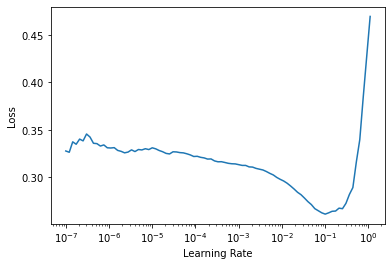

In [15]:
lr, lr_step = learn.lr_find()

In [16]:
print(lr, lr_step)

0.010000000149011612 0.04786301031708717


In [17]:
learn.model_dir = MODEL_PATH # This is necessary, otherwise the library will try to save in a read_only location raising an error

The `fine_tune` uses the one_cycle policy and discriminative learning rate:
* Freezes the model and trains for `freeze_epochs` in one cycle, from very low learning rate until `base_lr`. 
* It halfs the base_lr: `base_lr /= 2`, unfreeze the model and runs other cycle for `epochs`. 
* The parameter `pct_start` is the percentage of the epochs for each cycle to train in the warm-up fase of the cosine annealing

Slices the learning rate `slice(base_lr/lr_mult, base_lr)` and distributes to the different layers of the model. The default value of `lr_mult=100`

In [18]:
learn.fine_tune(epochs=EPOCHS, base_lr=lr_step, freeze_epochs=1, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.054354,0.049465,0.861304,0.310541,03:18


epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.043097,0.042917,0.874392,0.339829,03:18
1,0.042094,0.042814,0.876720,0.376436,03:18
2,0.043631,0.042111,0.883859,0.362384,03:17
3,0.044159,0.043614,0.880704,0.372833,03:16
4,0.044664,0.052893,0.854889,0.359517,03:16
5,0.045931,0.043605,0.880548,0.400516,03:21
6,0.044060,0.046575,0.884997,0.366978,03:26
7,0.041283,0.042355,0.893068,0.439969,03:22
8,0.038334,0.222887,0.893585,0.482106,03:28
9,0.035166,0.209088,0.896844,0.476439,03:24


It definitely took a lot longer in my local runs during the competition to get to this F1 Score. Tha `AdamW` combined with the `Lookahead` really seemed to make a difference

As you can see, even when the Binary Cross Entropy in the Validation Set gets lower and the F1 Score gets better, the Focal Loss sometimes gets worse, so I used here just as metric and not loss.

Even if the last model of the training loop is not the best in terms of F1 Score or validatio loss, the model is still adjusting the parameters, so we save the model at the end for image size 128, this is not the time to save the best model yet, we reserve this for the bigger images in the end.

In [19]:
learn.save('model-0-128') # Save the model of fold 0 for the size 128
gc.collect()

12603

Let's check how our model is doing

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

In [21]:
interp.most_confused() # actual, predicted, # of ocurrences

[('Cytosol', 'Centrosome', 1731), ('Centrosome', 'Cytosol', 241)]

Our model is still pretty bad. It has a hard time distinguising between Cytosol and Centrosome.

Let's see the worst predictions

,target,predicted,probabilities,loss
0,Mitochondria,Centrosome;Nucleoli fibrillar center;Nucleoplasm,"tensor([ 241.6250, -21.4375, -184.3750, -268.0000, -380.0000, -451.7500,\n -425.7500, 21.5938, 99.0625, -103.5625])",31.514062881469727
1,Mitochondria,Centrosome;Cytosol;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 218.5000, 35.7812, -30.1406, -41.0938, -110.3125, -97.6875,\n -194.2500, 166.8750, 68.5000, 28.0000])",27.9375
2,Mitochondria,Centrosome;Cytosol;Nucleoli fibrillar center;Nucleoplasm,"tensor([ 230.3750, 2.3359, -107.0000, -145.2500, -279.7500, -421.7500,\n -405.5000, 18.9375, 118.5000, -34.1875])",25.75406837463379
3,Mitochondria,Centrosome;Cytosol;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 186.6250, 67.3750, -20.6406, -32.4375, -57.1875, -51.7188,\n -171.3750, 166.8750, 47.9062, 6.0859])",25.363967895507812
4,Mitochondria;Nucleoplasm,Centrosome;Cytosol;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 178.6250, 81.0000, -18.9844, -14.9531, -50.0625, -64.5000,\n -198.2500, 176.5000, 60.9062, 10.6562])",23.086694717407227
5,Mitochondria,Centrosome;Nucleoplasm,"tensor([ 105.4375, -37.9062, -102.0000, -147.3750, -247.0000, -426.2500,\n -371.2500, -97.0625, 102.5000, -45.6875])",17.765625
6,Mitochondria,Centrosome;Cytosol;Mitochondria;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 35.2812, 14.6484, -2.3691, 0.7129, -12.5078, -10.5781, -41.1250,\n 39.1562, 10.4531, 1.2383])",5.023977279663086
7,Nucleoli fibrillar center,Cytosol;Nuclear bodies,"tensor([-47.7812, 6.2695, -76.9375, -49.0938, 22.4844, -48.4688, -24.9844,\n -65.8125, -11.2031, -21.4219])",4.727231025695801
8,Nucleoli fibrillar center,Cytosol;Nuclear bodies,"tensor([-49.4688, 4.1758, -70.1250, -45.3438, 22.1094, -46.4375, -24.3906,\n -67.2500, -8.9375, -23.2656])",4.671226978302002


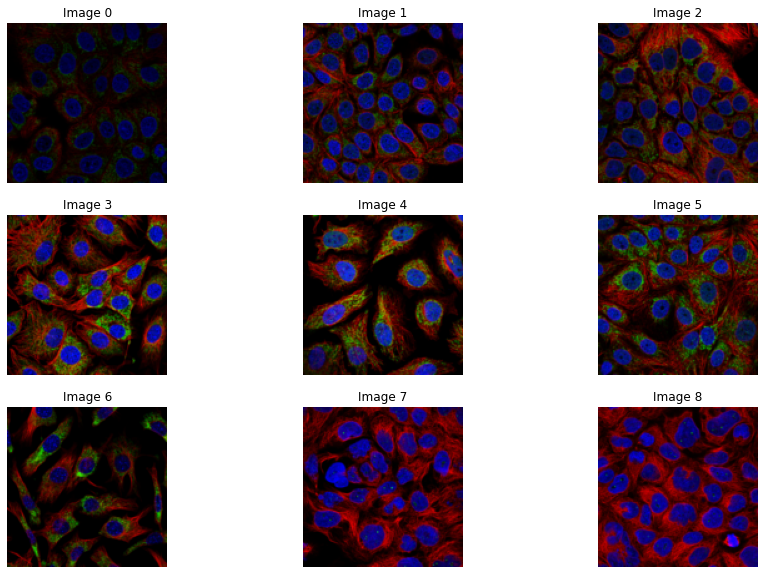

In [22]:
interp.plot_top_losses(9, figsize=(15,10))

The interpretation also shows the model misses a lot of predictions for Cytosol

Now we train a little more but without the warm-up part of the learning rate: `pct_start=0` and no freezing part.

In [23]:
learn.load('model-0-128', with_opt=True)
learn.fine_tune(epochs=EPOCHS, base_lr=lr_step/10, freeze_epochs=0, pct_start=0)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.033155,0.128804,0.904346,0.496300,03:25
1,0.032929,0.056103,0.905794,0.490091,03:22
2,0.032243,0.041169,0.908536,0.504987,03:18
3,0.031073,0.033486,0.908898,0.513446,03:16
4,0.031658,0.033263,0.909622,0.511651,03:16
5,0.031043,0.054274,0.909519,0.516035,03:16
6,0.031310,0.046190,0.911019,0.507210,03:16
7,0.030925,0.030925,0.911433,0.515642,03:15
8,0.030455,0.030768,0.912468,0.521023,03:14


## Train with bigger images

Now we create a new dataloader with bigger image size and lower batch_size and just replace it in the learner. It's normal for the model to get worse than the previous one in the beginning, since the image size duplicated it gets a little time for the model to adjust and then get better, now we just freeze again for the first 4 epochs. 

In [24]:
# Define new dataloaders, bigger size and smaller batch size
dls = get_dataloaders(df, bs=BATCH_SIZE * 2, size=IMG_SIZE//2)

# Substitute the learner dataloader
learn.dls = dls 

# Load the Previous Weights
learn.load('model-0-128', with_opt=True)


learn.fine_tune(epochs=EPOCHS, base_lr=lr_step, freeze_epochs=0, pct_start=0.5)


learn.save('model-0-256')

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.034313,0.465188,0.859545,0.327562,04:14
1,0.037844,0.288759,0.867253,0.350665,04:14
2,0.040624,0.123891,0.863166,0.346607,04:13
3,0.046043,0.096721,0.850129,0.274715,04:13
4,0.045379,0.690779,0.842783,0.353864,04:14
5,0.046826,13.002740,0.782204,0.262809,04:13
6,0.045020,11.599158,0.743507,0.282409,04:13
7,0.042513,0.771313,0.871650,0.359778,04:13
8,0.038697,0.574638,0.836265,0.368347,04:17
9,0.032892,2.627355,0.778893,0.358184,04:22


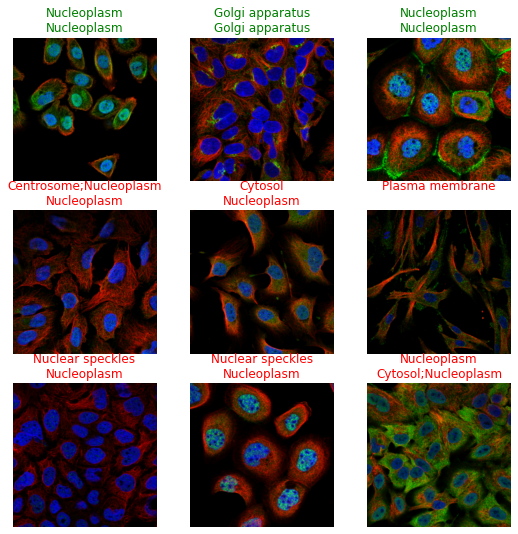

In [25]:
learn.load('model-0-256', with_opt=True)
learn.show_results()

* Top: True Label
* Bottom: Prediction

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

In [27]:
interp.most_confused() # actual, predicted, # of ocurrences

[('Centrosome', 'Cytosol', 1927), ('Cytosol', 'Centrosome', 1754)]

It definitely got better, remember that we use very basic data augmentations here.

,target,predicted,probabilities,loss
0,Nucleoplasm,Centrosome;Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 72.8750, 194.3750, 164.6250, 404.5000, 127.5000, 413.2500, 79.5000,\n 208.1250, 98.7500, 255.1250])",95.9937515258789
1,Nucleoli;Nucleoplasm,Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([-42.3125, 130.0000, 177.0000, 317.2500, 165.8750, 482.2500, -5.3438,\n 117.8125, 82.3750, 304.5000])",84.999267578125
2,Nucleoplasm,Centrosome;Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 42.2188, 111.5000, 148.7500, 345.2500, 113.9375, 384.5000, 27.3750,\n 186.1250, 77.1250, 240.5000])",80.0078125
3,Nucleoplasm,Centrosome;Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 41.1875, 143.2500, 158.2500, 420.5000, 72.6250, 338.0000, 19.0312,\n 132.1250, 123.9375, 252.1250])",78.85469055175781
4,Nucleoplasm,Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([-24.7969, 133.1250, 159.0000, 334.2500, 65.8750, 368.7500, -0.9106,\n 47.9688, 121.4375, 263.5000])",68.62483215332031
5,Cytosol;Nucleoplasm,Centrosome;Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 17.8438, 144.2500, 113.0000, 307.7500, 91.2500, 341.2500, 74.0625,\n 175.1250, 70.1250, 211.5000])",66.58906555175781
6,Nucleoplasm,Centrosome;Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 50.3750, 94.1875, 80.2500, 246.7500, 57.8125, 200.5000, 60.2500,\n 148.1250, 57.0938, 142.8750])",54.056251525878906
7,Nucleoplasm,Centrosome;Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 17.4062, 118.3125, 76.2500, 228.1250, 66.3750, 225.8750, 66.1250,\n 126.3750, 45.4062, 141.3750])",53.31093978881836
8,Nucleoplasm;Plasma membrane,Centrosome;Cytosol;Golgi apparatus;Mitochondria;Nuclear bodies;Nuclear speckles;Nucleoli;Nucleoli fibrillar center;Nucleoplasm;Plasma membrane,"tensor([ 0.4419, 106.0000, 102.6875, 269.0000, 86.5625, 285.2500, 24.2812,\n 151.8750, 52.1562, 190.5000])",51.30019760131836


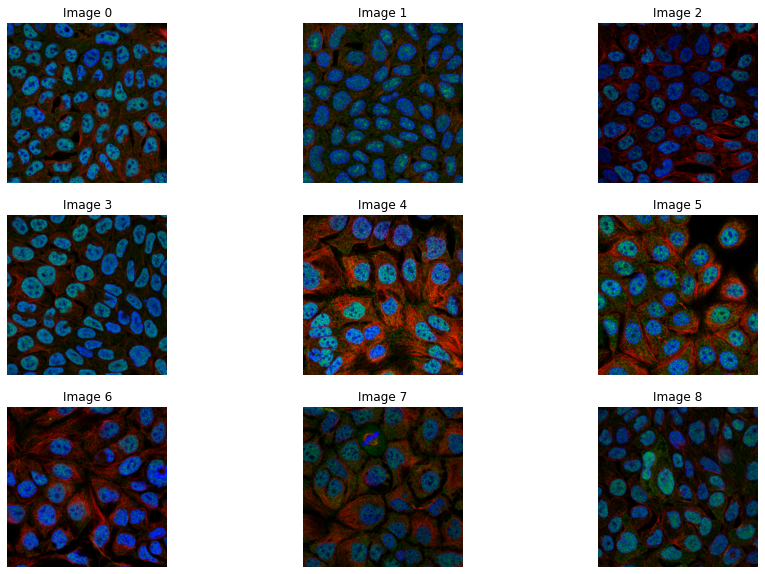

In [28]:
interp.plot_top_losses(9, figsize=(15,10))

In [29]:
interp.plot_top_losses(9, figsize=(15,10)

SyntaxError: unexpected EOF while parsing (<ipython-input-29-10cded1b7ba8>, line 1)

Now let's a little more

In [30]:
learn.load('model-0-256', with_opt=True)
learn.fine_tune(epochs=EPOCHS, base_lr=lr_step, freeze_epochs=0, pct_start=0)
learn.save('model-0-256')

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.045726,0.291499,0.861097,0.387560,04:20
1,0.043124,0.967574,0.839990,0.358452,04:20
2,0.040312,2.503280,0.803052,0.379575,04:22
3,0.038820,0.273957,0.857320,0.426578,04:24
4,0.036382,1.716640,0.838282,0.398901,04:28
5,0.033730,0.442778,0.862080,0.391851,04:23
6,0.032226,1.708209,0.858821,0.470304,04:20
7,0.030204,0.192483,0.885722,0.531946,04:21
8,0.028960,0.102025,0.893275,0.551944,04:22
9,0.027280,0.099563,0.894154,0.548147,04:20


Now let's train with the full size image, but since our model is already trained a little we are going to divide the learning rate again by 5, internally the lr is further divided by 2 in the unfrozen fase, this will make the lr 10 times lower from the last cycle and a 100 times lower than the original one.

In [31]:
#dls = get_dataloaders(df, bs=BATCH_SIZE, size=IMG_SIZE)

# Substitute the learner dataloader
#learn.dls = dls 

# Load the Previous Weights
#learn.load('model-0-256') 

Now let's add some helpful callbacks. Callbacks are modifiers of the training loop in fastai, it basically everything is done with Callbacks under the hood. We pass them as a list to the argument `cbs`. We are going to save the model with the best validation loss and also stops the training if the model doesn't get better after 5 epochs.

In [32]:
#cbs = [EarlyStoppingCallback(monitor='valid_loss', patience=4)]

#cbs += [SaveModelCallback(monitor='valid_loss', fname='model-0-512')]

#learn.fine_tune(EPOCHS * 2, lr, freeze_epochs=4, cbs=cbs) 

In [33]:
#gc.collect() #free up some memory

Let's check now how much our model improved. 

In [34]:
#learn.load('model-0-512')
#learn.show_results(max_n=15)

In [35]:
#interp = ClassificationInterpretation.from_learner(learn)

In [36]:
#interp.most_confused() # actual, predicted, # of ocurrences

In [37]:
#interp.plot_top_losses(9, figsize=(15,10))

This was just a training flow of 1 fold using very simple augmentations. It can be heavily improved if used the tips in the next steps

In [38]:
# Get the predictions on the validation set
preds, targs = learn.get_preds()

## Finding the Thresholds which maximizes the F1 Score in the validation set 

In [39]:
from pprint import pprint as pp

# Let's get the thresholds which maximizes the F1_score for this train,valid split.
th, score = get_threshold(preds, targs)

print('The best threshold for this fold is: \n')
pp(th)
print(f'\nThe F1 Score using these threshold is: {score}')

The best threshold for this fold is: 

array([ -0.17098706,   0.17182128,  -0.51176182,  -0.91352208,
        -0.5628634 ,  -1.15371632,  -0.75174315,   0.1889103 ,
       -12.06889611,  -0.71505931])

The F1 Score using these threshold is: 0.5775935448935248


As you can see the thresholds are very different from each other. To use a single number as threshold limits a lot the capacity of our models. In the training workflow you should keep the different thresholds for the different fold and average them in the end to use in the validation set.

In [40]:
test_dl = learn.dls.test_dl(test_images, shuffle=False, drop_last=False)

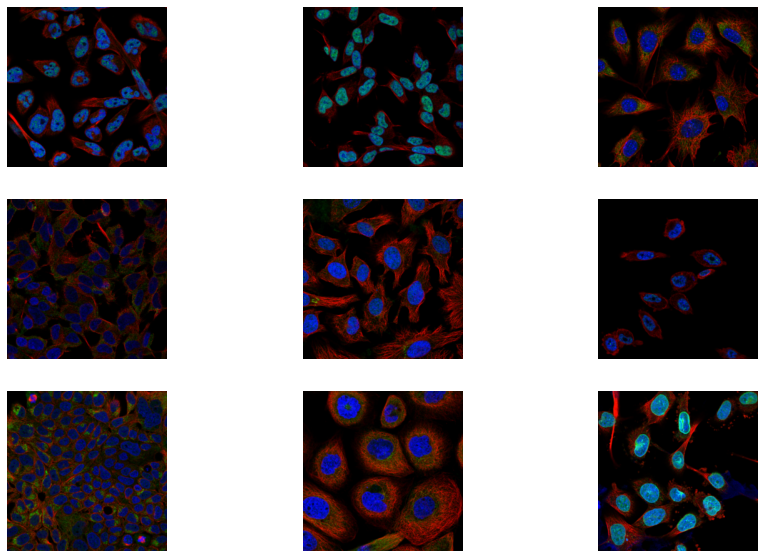

In [41]:
test_dl.show_batch(figsize=(15,10))

Double check to see if the order was preserved

In [42]:
test_dl.items[:5]

['../input/jovian-pytorch-z2g/Human protein atlas/test/24117.png',
 '../input/jovian-pytorch-z2g/Human protein atlas/test/15322.png',
 '../input/jovian-pytorch-z2g/Human protein atlas/test/14546.png',
 '../input/jovian-pytorch-z2g/Human protein atlas/test/8079.png',
 '../input/jovian-pytorch-z2g/Human protein atlas/test/13192.png']

In [43]:
submission.head()

,Image,Label
0,24117,0
1,15322,0
2,14546,0
3,8079,0
4,13192,0


In [44]:
# The reorder argument, just as the name implies, reorder the results to the original order, Since we didn't shuffle it, we don't reorder here
preds_test, targs_test, decoded_preds = learn.get_preds(dl=test_dl, reorder=False, with_decoded=True) 

`preds_test` is the actual vector with the probabilities returned by the model with the activation function of the loss ( in this case `torch.sigmoid` ) applied to them. The targs_test is `null` since we don't have the truth label of the test set.
The `decoded_preds` is the boolean vector resulted from the comparison of `preds_test` using a fixed threshold (0.5 by default in the loss function but you can change it ). This is returned because of the argument `with_decoded=True`. If you don't want this remove the argument because the default is `False` 

Since we have a custom threshold, we'll use just the `preds_test` tensor and compare it with the threshold tensor. Then you can compare your results with the `decoded_test` tensor.

In [45]:
predictions = preds_test > torch.from_numpy(th)

Let's check how much of our predictions differ when using the fitted thresholds  against the default 0.5.

In [46]:
(predictions != decoded_preds).sum().item()

9219

In [47]:
submission["Label"] = [decode_target(label) for label in predictions]
submission.to_csv('submission.csv', index=False)

## Test Time Augmentation
In TTA the model gets a validations / test image, makes a center crop in it and other `n` transforms in the whole dataset and return the average of the predictions. It's another way to improve the generalization of your model. 

In [48]:
# Get the predictions on the validation set
preds, targs = learn.tta(n=8)

## Finding the Thresholds which maximizes the F1 Score in the validation set ( Now using TTA )

In [49]:
from pprint import pprint as pp

# Let's get the thresholds which maximizes the F1_score for this train,valid split.
th, score = get_threshold(preds, targs)

print('The best threshold for this fold is: \n')
pp(th)
print(f'\nThe F1 Score using these threshold is: {score}')

The best threshold for this fold is: 

array([-0.47379216, -0.15113966, -0.60025025, -0.49777782, -0.45180979,
       -0.56711883, -0.50688899, -0.53719271, -3.5944509 , -0.47046842])

The F1 Score using these threshold is: 0.6876597845083247


In [50]:
predictions = preds_test > torch.from_numpy(th)

In [51]:
preds_test, _ = learn.tta(dl=test_dl, n=8) 

In [52]:
predictions = preds_test > torch.from_numpy(th)

Let's check how much of our predictions differ when using the fitted thresholds  against the default 0.5.

In [53]:
(predictions != decoded_preds).sum().item()

10260

In [54]:
submission["Label"] = [decode_target(label) for label in predictions]
submission.to_csv('submission_tta.csv', index=False)

# Next Steps
* Use the `Mixup` Callback: `cnn_learner(...cbs=Mixup())`. This is a ingenious trick that create images that are part one label and part the other. It makes for a really powerfull augmentation technique and can fight the class imbalance. The same observation from the other item applies. Don't load any saved weights because the data will be fundamentally different. Also Mixup requires more epochs to converge but can improve considerably the robustness of your models.
* Run different folds of cross-validation, save the model weights, thresholds and predictions on the test set. In the end you can average the predictions and average of the thresholds and submit this as a final predictions.
* Test other architectures

For more details, check my other notebook https://www.kaggle.com/ronaldokun/multilabel-stratification-cv-and-ensemble


If this code seems to much don't worry. It takes a little time to get used to fastai code but it can do wonders to your training workflow and has lots of cool features. 
You don't need the complicated function of the loss or optimizer, you can ignore those obscure parts.